## RQ3: Cross version prediction
## Deliverables
1. Confusion matrix for each learner x 1  = 1 CM.
2. Performance metrics (Accuracy, Precision and Recall) for each learner x 1 learners = 1 rows of metrics.
3. AUC-ROC curve for all learners x 1 graph = 1 AUC-ROC graph.

## Learners
1. XGBoost Classifier

## Feature set
1. RFE

## Datasets
1. Apache Tomcat
2. Apache Struts2-core

### Prerequisites

In [98]:
# Basic imports
import numpy as np
import pandas as pd
import sys

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE

# Handling imbalance data
from imblearn.over_sampling  import RandomOverSampler
from imblearn.under_sampling  import RandomUnderSampler

# CV
from sklearn.model_selection import StratifiedKFold

# Performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
from matplotlib import pyplot as plt
from numpy import mean
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import roc_curve

#ML models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

def preprocess(dataset_idx, target):
    ds = ["./datasets/tomcat-final.csv", "./datasets/struts-final.csv"]
    df = pd.read_csv(ds[dataset_idx])
    np.set_printoptions(threshold=np.inf)
    pd.set_option('max_columns', None)
    print(f"Dataframe {ds[dataset_idx][-16:]} created..\nTotal number of rows: ", df.shape[0])
    return split_features_variables(df, target)

def split_features_variables(df, target):
    y_cols = ['vulnerable', 'severity', 'title']
    feature_columns = df.columns[2:-4]
    train, test = train_test_split(df, shuffle=True,test_size=0.3)
    X = train[feature_columns]
    test_X = test[feature_columns]
    if y_cols[target] == 'vulnerable':
        return X, test_X, train[y_cols[target]], test[y_cols[target]]      
    else: 
        label_X_train, label_X_test, label_mapping= label_encode(train, test, y_cols[target])
        return X, test_X, label_X_train[y_cols[target]], label_X_test[y_cols[target]], label_mapping

def label_encode(train, test, target):
    print('Labelled target found..')
    train_target = train.copy()
    test_target = test.copy()
    df = train.append(test, ignore_index=True)
    le = LabelEncoder()
    le.fit(df[target])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_target[target] = le.transform(train[target])
    test_target[target] = le.transform(test[target])
    print('Encoded...')
    return train_target, test_target, le_name_mapping

def fit_feature_set(feature_set):
    global X_ros
    X_ros = X_ros[feature_set]
    global test_X
    test_X = test_X[feature_set]
  
def predict(model, target):
    model.fit(X_ros, y_ros)
    predictions = model.predict(test_X)
    pred_proba = model.predict_proba(test_X)
    accuracy = accuracy_score(test_Y, predictions)
    average = ''
    if target != 0:
      average = 'micro'
    else:
      average = 'binary'
    precision = precision_score(test_Y, predictions, average=average)
    recall = recall_score(test_Y, predictions,average=average)
    return [accuracy, precision, recall, pred_proba ,predictions]

def train_test_split(index=0):
  df = pd.read_csv(ds[index])
  versions = df.version.unique()
  train = []
  test = []
  # Get all the test datasets.
  for v in versions:
    if not v == versions[0]:
      test.append(df.loc[df.version==v])
  # Get all the train datasets
  for v in versions:
    if not v == versions[0]:
      temp = []
      for v1 in range(0,np.where(versions==v)[0][0]+1):
          temp.append(df.loc[df.version==versions[v1]])
      train.append(pd.concat(temp))
    else:
      train.append(df.loc[df.version==v])
  train.pop(-1)
  return train, test, df

In [257]:
index = 9
target = 2

ds = ["./datasets/tomcat-final.csv", "./datasets/struts-final.csv"]
train, test, df = train_test_split(1)

np.set_printoptions(threshold=np.inf)
pd.set_option('max_columns', None)
print(f'Maximum possible index: {len(train)-1}')
print(f'Current index: {index}')
targets = ['vulnerable','severity','title']
print(f'Current target: {targets[target]}')
feature_columns = df.columns[2:-4]
X, test_X = train[index][feature_columns], test[index][feature_columns]
if not target == 0:
    label_X_train, label_X_test, label_mappings = label_encode(train[index],test[index], targets[target])
    y, test_Y = label_X_train.pop(targets[target]), label_X_test.pop(targets[target])
else:
    y, test_Y = train[index].pop(targets[target]), test[index].pop(targets[target])
ros = RandomUnderSampler()
X_ros, y_ros = ros.fit_resample(X, y)
if len(label_mappings) > 0:
  labels = label_mappings.keys()
  values = label_mappings.values()
  print(pd.DataFrame([labels, values]).T)

Maximum possible index: 9
Current index: 9
Current target: title
Labelled target found..
Encoded...
                                                 0  1
0                                                0  0
1                        Access Restriction Bypass  1
2                Cross-site Request Forgery (CSRF)  2
3                          Denial of Service (DoS)  3
4                     Improper Action Name Cleanup  4
5     Regular Expression Denial of Service (ReDoS)  5
6                            Remote Code Execution  6
7                      Remote Code Execution (RCE)  7
8  Unrestricted Upload of File with Dangerous Type  8


### Machine Learning



-----Model: XGBoost Classifier-----
Accuracy: 0.23842592592592593
Precision: 0.23842592592592593
Recall: 0.23842592592592593


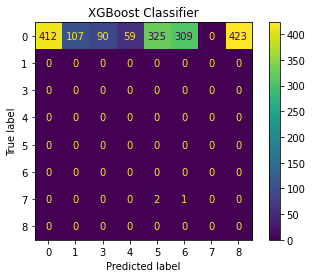

In [258]:
# Random Feature Eliminator
rfe = RFE(estimator=DecisionTreeClassifier())
rfe.fit(X_ros, y_ros)
rfe_features = []
for i in range(X.shape[1]):
    if(rfe.support_[i] == 1):
        rfe_features.append(X.columns[i])
fit_feature_set(rfe_features)

# XGBoost
if target == 0:
  xgb = XGBClassifier(n_estimators=500, objective='binary:logistic')
else:
  xgb = XGBClassifier(n_estimators=500,objective='multi:softmax')
xgb_pred_arr = predict(xgb,target)
xgb_pred = xgb_pred_arr[-2]
print('\n-----Model: XGBoost Classifier-----')
print(f'Accuracy: {mean(xgb_pred_arr[0])}')
print(f'Precision: {mean(xgb_pred_arr[1])}')
print(f'Recall: {mean(xgb_pred_arr[2])}')
xgb_fig = CMD.from_predictions(test_Y,xgb_pred_arr[-1])
xgb_fig.ax_.set_title('XGBoost Classifier')
print(xgb_fig)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


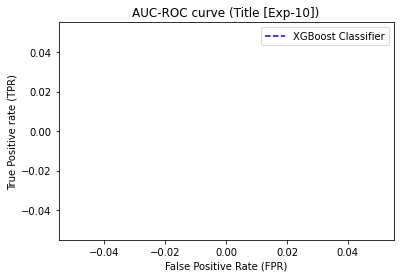

In [259]:
# roc curve for models
fpr = {}
tpr = {}
thresh ={}
    
fpr1, tpr1, thresh1 = roc_curve(test_Y, xgb_pred[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_Y))]
p_fpr, p_tpr, _ = roc_curve(test_Y, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='blue', label='XGBoost Classifier')

# title
plt.title('AUC-ROC curve ('+targets[target].capitalize()+' [Exp-'+str(index+1)+'])')
# x label
plt.xlabel('False Positive Rate (FPR)')
# y label
plt.ylabel('True Positive rate (TPR)')

plt.legend(loc='best')
plt.show();